In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

## Models trained using a PMG mask

Since the PMG and CF regions become distorted during simulations, here we would like to use a myosin PCA that doesn't consider those troublesome regions

(236, 200)


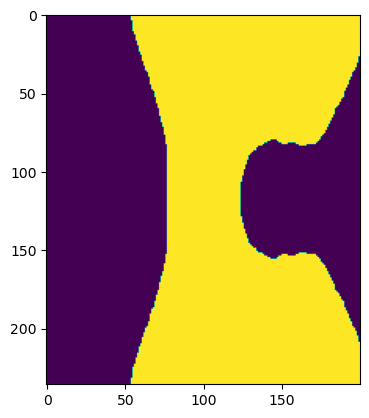

In [ ]:
from PIL import Image
from skimage.transform import resize
from skimage.morphology import binary_dilation, binary_erosion
pmg_mask = np.array(Image.open('../flydrive/Masks/MAX_WT_PMG_mask.tiff'))
cf_mask = np.array(Image.open('../flydrive/Masks/MAX_WT_CF_mask.tiff'))

pmg_mask = np.array(pmg_mask)
cf_mask = np.array(cf_mask)
total_mask = resize(pmg_mask + cf_mask, (236, 200))
total_mask = (total_mask + total_mask[::-1]) > 0
n = 3
total_mask = ~binary_erosion(total_mask, np.ones([n, n]))
total_mask
print(total_mask.shape)
plt.imshow(total_mask)
np.save('../flydrive/Masks/pmg_cf_mask', total_mask)

## Build PCA models from datasets

100%|██████████| 6/6 [00:00<00:00, 958.19it/s]


(422, 16) (422, 16)


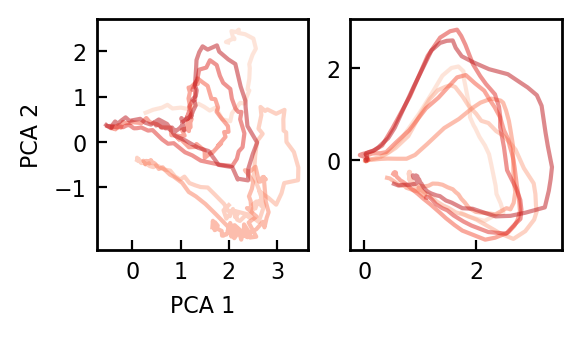

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
from morphogenesis.decomposition.decomposition_utils import get_decomposition_model
from morphogenesis.plot_utils import plot_scalar, plot_tensor
from morphogenesis.dataset import *

from build_PCA_models import build_decomposition_model

pmg_cf_mask = np.load('../flydrive/Masks/pmg_cf_mask.npy')

transform = Reshape2DField()
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, 
                           drop_time=True, tmin=-15, tmax=45)
sqh_model, _ = build_decomposition_model(sqh_dataset, crop=40, model_name='SVDPipeline_PMGCrop', mask=pmg_cf_mask)

vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, 
                            drop_time=True, tmin=-15, tmax=45)
vel_model, _ = build_decomposition_model(vel_dataset, crop=0, model_name='SVDPipeline_NoCrop')

plt.rcParams['axes.linewidth'] = 1

fig, ax = plt.subplots(1, 2, figsize=(3, 1.5), dpi=200)

df = sqh_dataset.df.copy()
colors = plt.cm.Reds(np.linspace(0.2, 0.8, len(df.embryoID.unique())))

X = []
y0 = []

for i, embryoID in enumerate(df.embryoID.unique()):
    sqh = sqh_model.transform(sqh_dataset.values[embryoID])
    vel = vel_model.transform(vel_dataset.values[embryoID])

    ax[0].plot(sqh[:,0], sqh[:,1], c=colors[i], alpha=0.5)
    ax[1].plot(vel[:,0], vel[:,1], c=colors[i], alpha=0.5)

    X.append(sqh)
    y0.append(vel)

X = np.concatenate(X)
y0 = np.concatenate(y0)
print(X.shape, y0.shape)

ax[0].set(xticks=[0, 1, 2, 3], yticks=[-1, 0, 1, 2], xlabel='PCA 1', ylabel='PCA 2');